## Download del dataset dalla libreria medmnist

In [ ]:
!pip install medmnist

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import ravel

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


from medmnist.dataset import PneumoniaMNIST
Dataset = PneumoniaMNIST
dataset = Dataset(split='val', download=True)
label_map = dataset.info['label']

Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz


# Informazioni su PneumoniaMNIST
PneumoniaMNIST si basa su un set di dati precedenti di __5.856 immagini__ radiografiche del torace pediatrico.  
Il compito è la classificazione a classi binarie della polmonite rispetto alla normalità. Abbiamo diviso il set di formazione di origine con un rapporto di 9:1 in set di formazione e di convalida e abbiamo usato il set di convalida di origine come set di test.  
Le immagini di partenza sono in scala di grigi e le loro dimensioni sono (384-2.916)×(127-2.713). Le immagini vengono ritagliate al centro e ridimensionate in __1×28×28__.

Le immagini sono classificate:
- 0: __normale__
- 1: __polmonite__

Divisione del dataset:
{'train': 4708, 'val': 524, 'test': 624}


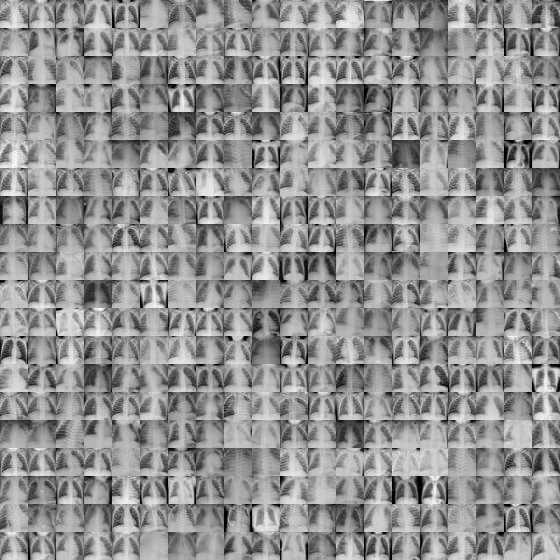

In [3]:
print("Divisione del dataset:")
print(dataset.info['n_samples'])
dataset.montage(20)

# Estrazione del train set e del test set

In [4]:
X_train, Y_train = Dataset(split='train',download=True).imgs, Dataset(split='train',download=True).labels
X_test, Y_test = Dataset(split='test',download=True).imgs, Dataset(split='test',download=True).labels

Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/angelolongano/.medmnist/pneumoniamnist.npz


Trasformo la matrice dell'immagine in un vettore

In [5]:
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)

## Sistemo il formato delle etichette

In [6]:
Y_train

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=uint8)

In [7]:
Y_train = ravel(Y_train)
Y_test = ravel(Y_test)

In [8]:
Y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=uint8)

## Bilanciamento del dataset

In [9]:
# Bilanciamento delle classi nel training set
print(pd.Series(Y_train).value_counts())

1    3494
0    1214
Name: count, dtype: int64


In [10]:
# Bilanciamento delle classi nel test set
print(pd.Series(Y_test).value_counts())

1    390
0    234
Name: count, dtype: int64


## Esempio delle immagini che verranno classificate

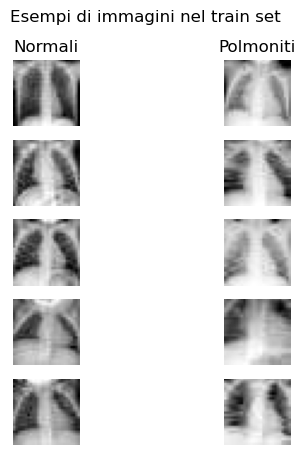

In [11]:
from numpy import reshape

normals_indicies = np.where(Y_train == 0)[0]
pneumonias_indicies = np.where(Y_train == 1)[0]

normals = X_train[normals_indicies]
pneumonias = X_train[pneumonias_indicies]

fig, ax = plt.subplots(5, 2, figsize=(5, 5))
fig.suptitle('Esempi di immagini nel train set')
ax[0, 0].set_title('Normali')
ax[0, 1].set_title('Polmoniti')
for i in range(5):
    ax[i, 0].imshow(reshape(normals[i],(28,28)), cmap='gray')
    ax[i, 1].imshow(reshape(pneumonias[i],(28, 28)), cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

# Classificazione binaria del dataset

## Minimi vicini

In [12]:
grid = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': range(1, 100)}, n_iter=20, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train, Y_train)
search_params.best_params_

{'n_neighbors': 14}

In [13]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_neighbors","mean_score_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_NEIGHBORS,MEAN_SCORE_TIME,MEAN_TEST_SCORE
13,1,14,"0,36712747","0,94753537"
6,2,17,"0,34940586","0,94732351"
14,3,8,"0,32258759","0,94689820"
19,4,9,"0,15844007","0,94604827"
16,5,23,"0,32148061","0,94350005"
17,6,25,"0,36232834","0,94286220"
0,7,27,"0,25698252","0,94265034"
18,8,34,"0,30910096","0,94201340"
15,9,31,"0,33765135","0,94095160"
2,10,3,"0,55006199","0,93925151"


(0.0, 1.0)

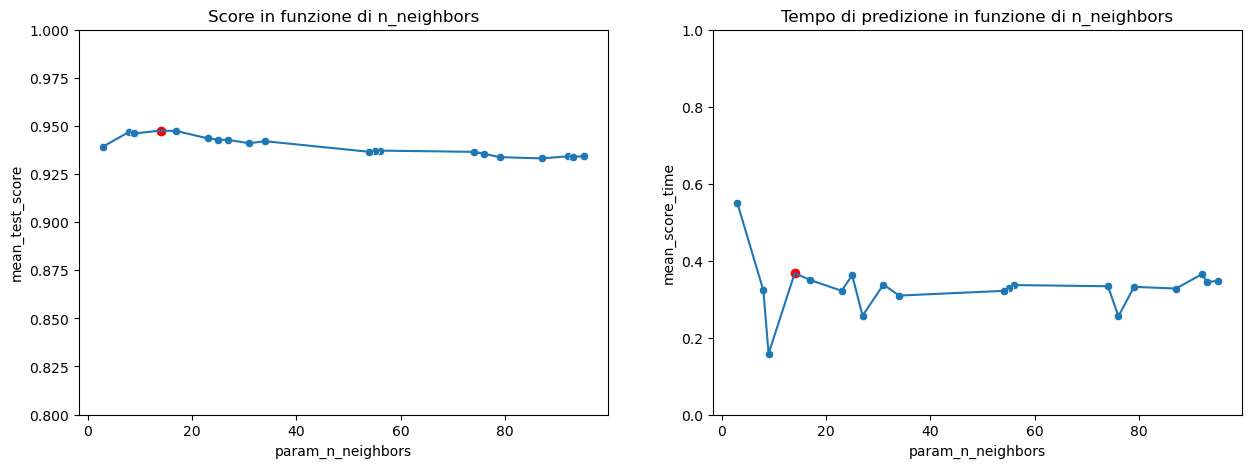

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_neighbors = best.param_n_neighbors
ax[0].scatter(best.param_n_neighbors, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1]).set_title('Tempo di predizione in funzione di n_neighbors')
sns.scatterplot(data=df, x='param_n_neighbors', y='mean_score_time', ax=ax[1])
ax[1].scatter(best.param_n_neighbors, best.mean_score_time, color='red')
ax[1].set_ylim(0,1)

In [15]:
cls = KNeighborsClassifier(n_neighbors=best_n_neighbors,n_jobs=-1)
cls.fit(X_train, Y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=14)

In [16]:
y_pred_kn = cls.predict(X_test)

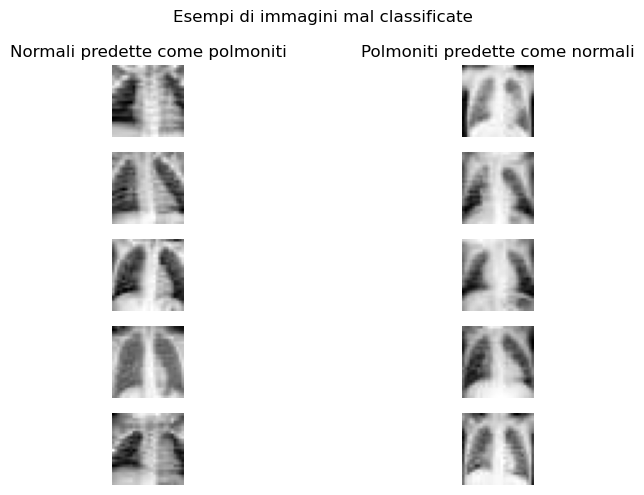

In [17]:
real_0_pred_1 = np.where((Y_test == 0) & (y_pred_kn == 1))[0]
real_1_pred_0 = np.where((Y_test == 1) & (y_pred_kn == 0))[0]

fig, ax = plt.subplots(5, 2, figsize=(10, 5))
fig.suptitle('Esempi di immagini mal classificate')
ax[0, 0].set_title('Normali predette come polmoniti')
ax[0, 1].set_title('Polmoniti predette come normali')
for i in range(5):
    ax[i, 0].imshow(reshape(X_test[real_0_pred_1[i]],(28,28)), cmap='gray')
    ax[i, 1].imshow(reshape(X_test[real_1_pred_0[i]],(28, 28)), cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()

## Random Forest

In [18]:
grid = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1,random_state=0), {'n_estimators': range(1, 1000), 'max_depth': range(1,100)}, n_iter=20, n_jobs=-1,random_state=0)
search_params = grid.fit(X_train, Y_train)
search_params.best_params_

{'n_estimators': 337, 'max_depth': 69}

In [19]:
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by='rank_test_score', inplace=True)
df[["rank_test_score","param_n_estimators","param_max_depth","mean_fit_time","mean_test_score"]].style \
  .format(precision=8, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1)

,RANK_TEST_SCORE,PARAM_N_ESTIMATORS,PARAM_MAX_DEPTH,MEAN_FIT_TIME,MEAN_TEST_SCORE
0,1,337,69,"12,98105998","0,94944846"
2,2,656,43,"25,06549263","0,94944823"
13,3,552,40,"20,84245572","0,94902338"
10,3,552,81,"21,08009830","0,94902338"
12,5,649,49,"24,43894782","0,94902315"
14,6,673,53,"25,46751299","0,94881084"
1,7,611,44,"23,51459918","0,94881061"
19,8,778,90,"15,21399240","0,94859875"
6,9,737,98,"28,19352579","0,94859852"
3,10,937,46,"35,86014738","0,94838643"


(0.0, 50.0)

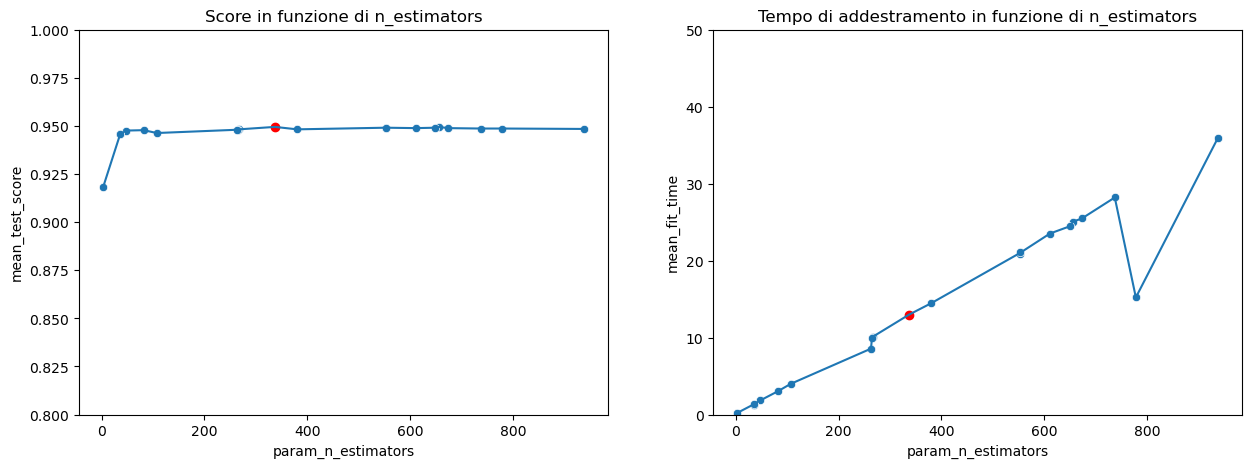

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

sns.lineplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0]).set_title('Score in funzione di n_estimators')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=ax[0])
# visualizza in rosso il miglior modello
best = df.iloc[0]
best_n_estimators = best.param_n_estimators
best_max_depth = best.param_max_depth
ax[0].scatter(best.param_n_estimators, best.mean_test_score, color='red')
ax[0].set_ylim(0.8,1)

sns.lineplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1]).set_title('Tempo di addestramento in funzione di n_estimators')
sns.scatterplot(data=df, x='param_n_estimators', y='mean_fit_time', ax=ax[1])
ax[1].scatter(best.param_n_estimators, best.mean_fit_time, color='red')
ax[1].set_ylim(0,50)

In [21]:
cls = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, n_jobs=-1)
cls.fit(X_train, Y_train)

RandomForestClassifier(max_depth=69, n_estimators=337, n_jobs=-1)

In [22]:
y_pred_rf = cls.predict(X_test)

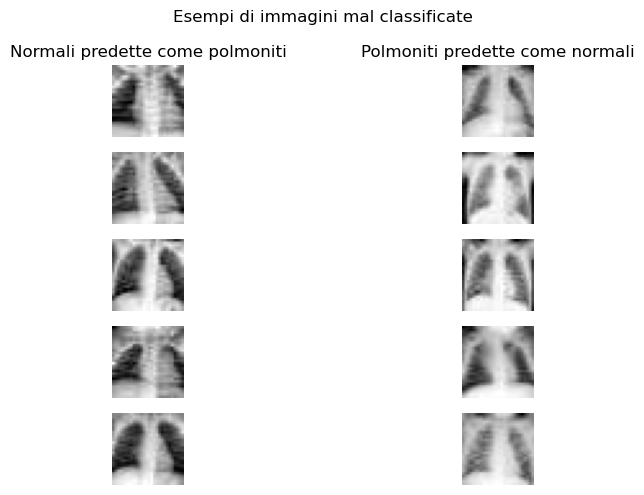

In [23]:
real_0_pred_1 = np.where((Y_test == 0) & (y_pred_rf == 1))[0]
real_1_pred_0 = np.where((Y_test == 1) & (y_pred_rf == 0))[0]

fig, ax = plt.subplots(5, 2, figsize=(10, 5))
fig.suptitle('Esempi di immagini mal classificate')
ax[0, 0].set_title('Normali predette come polmoniti')
ax[0, 1].set_title('Polmoniti predette come normali')
for i in range(5):
    ax[i, 0].imshow(reshape(X_test[real_0_pred_1[i]],(28,28)), cmap='gray')
    ax[i, 1].imshow(reshape(X_test[real_1_pred_0[i]],(28, 28)), cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()

## Minimi vicini vs Random Forest

In [24]:
print(f"Minimi vicini: \n{classification_report(Y_test, y_pred_kn)}\n\n")
print(f"Random Forest: \n{classification_report(Y_test, y_pred_rf)}")

Minimi vicini: 
              precision    recall  f1-score   support

           0       0.93      0.58      0.72       234
           1       0.79      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.86      0.78      0.80       624
weighted avg       0.85      0.83      0.82       624



Random Forest: 
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       234
           1       0.81      0.98      0.89       390

    accuracy                           0.84       624
   macro avg       0.88      0.80      0.82       624
weighted avg       0.86      0.84      0.84       624



Text(0.5, 1.0, 'Random Forest')

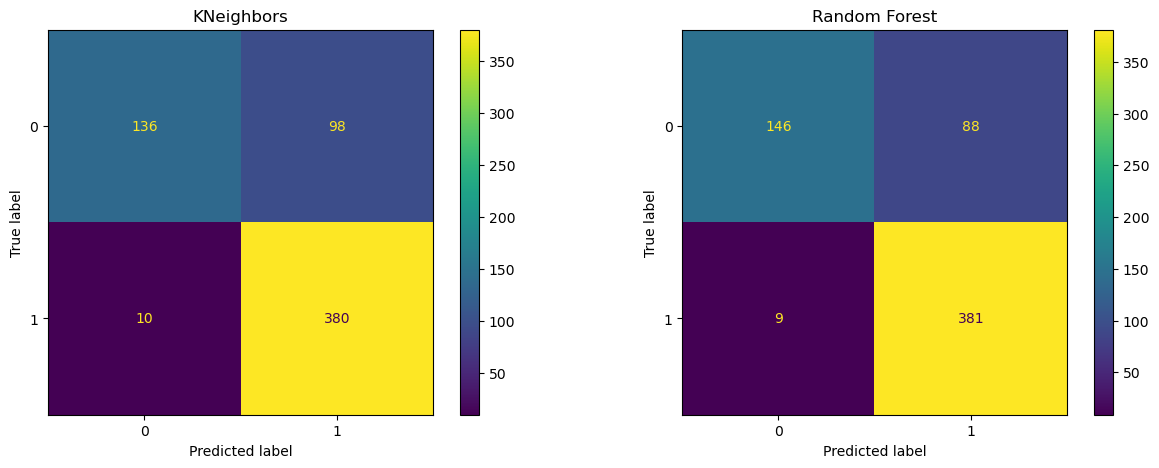

In [25]:
matrix_kn = confusion_matrix(Y_test, y_pred_kn)
matrix_rf = confusion_matrix(Y_test, y_pred_rf)

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ConfusionMatrixDisplay(matrix_kn).plot(ax=ax[0])
ax[0].set_title('KNeighbors')
ConfusionMatrixDisplay(matrix_rf).plot(ax=ax[1])
ax[1].set_title('Random Forest')

# Conclusioni

Osservando i risultati delle metriche si può dire che è stato raggiunto un risultato discreto per dei metodi di Machine Learning.  
Il __Random Forest__ è leggermente più preciso del metodo dei minimi vicini, ma da entrambi si è ottenuto un benchmark non troppo lontano da quello ottenuto dalle reti neurali.

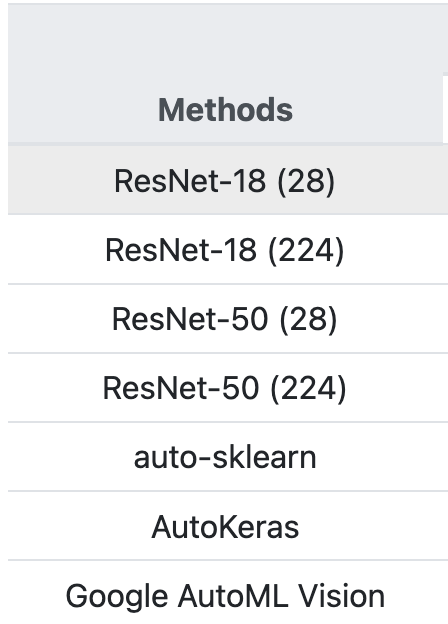
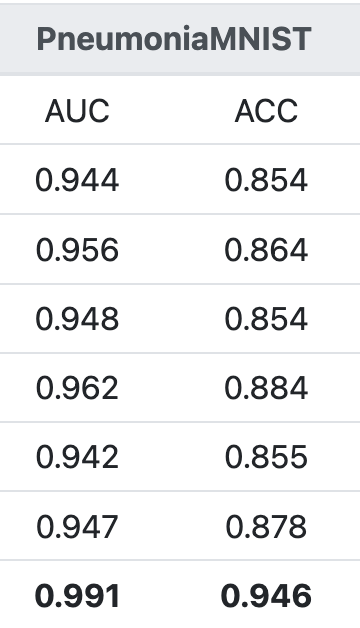


In [26]:
# Differenza di accuratezza tra i due modelli
print(f"Minimi vicini: \n\tAUC:{round(roc_auc_score(Y_test, y_pred_kn),2)} \tACC: {round(accuracy_score(Y_test, y_pred_kn),2)}\n")
print(f"Random Forest: \n\tAUC:{round(roc_auc_score(Y_test, y_pred_rf),2)} \tACC: {round(accuracy_score(Y_test, y_pred_rf),2)}\n")

Minimi vicini: 
	AUC:0.78 	ACC: 0.83

Random Forest: 
	AUC:0.8 	ACC: 0.84

